In [71]:
import sqlite3
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans

# Récupérer Data

In [72]:
con = sqlite3.connect("olist.db")
sql = pd.read_sql_query("Select * from rfm_table", con)
data = pd.DataFrame(sql)

data.shape

(110840, 5)

In [73]:
data.head()

order_id  ...   price
0  e481f51cbdc54678b7cc49136f2d6af7  ...   29.99
1  53cdb2fc8bc7dce0b6741e2150273451  ...  118.70
2  47770eb9100c2d0c44946d9cf07ec65d  ...  159.90
3  949d5b44dbf5de918fe9c16f97b45f8a  ...   45.00
4  ad21c59c0840e6cb83a9ceb5573f8159  ...   19.90

[5 rows x 5 columns]

In [74]:
agg = data.groupby("customer_unique_id").agg(
     frequency=pd.NamedAgg(column="order_id", aggfunc="count"),
     recency=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
     monetary=pd.NamedAgg(column="price", aggfunc="sum"),
     contentment=pd.NamedAgg(column="review_score", aggfunc="mean")
)

agg["recency"] = round(data["order_purchase_timestamp"].max() - agg["recency"])

agg.head()

frequency  recency  monetary  contentment
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2          1    111.0    129.90          5.0
0000b849f77a49e4a4ce2b2a4ca5be3f          1    114.0     18.90          4.0
0000f46a3911fa3c0805444483337064          1    537.0     69.00          3.0
0000f6ccb0745a6a4b88665a16c9f078          1    321.0     25.99          4.0
0004aac84e0df4da2b147fca70cf8255          1    288.0    180.00          5.0

In [75]:
agg.shape

(93358, 4)

# Nettoyer Data

## Explorer Data

In [76]:
agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93358 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   frequency    93358 non-null  int64  
 1   recency      93358 non-null  float64
 2   monetary     93358 non-null  float64
 3   contentment  92755 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.6+ MB


In [77]:
agg.loc[agg["contentment"].isna(), "contentment"] = agg["contentment"].median()

In [78]:
agg.describe()

frequency       recency      monetary   contentment
count  93358.000000  93358.000000  93358.000000  93358.000000
mean       1.187258    237.519527    142.246370      4.158828
std        0.650815    152.596929    216.931229      1.278213
min        1.000000      0.000000      0.850000      1.000000
25%        1.000000    114.000000     47.800000      4.000000
50%        1.000000    219.000000     89.900000      5.000000
75%        1.000000    346.000000    155.000000      5.000000
max       24.000000    713.000000  13440.000000      5.000000

## Visualiser Data

In [79]:
# agg = agg.loc[agg["recency"] < 700,]

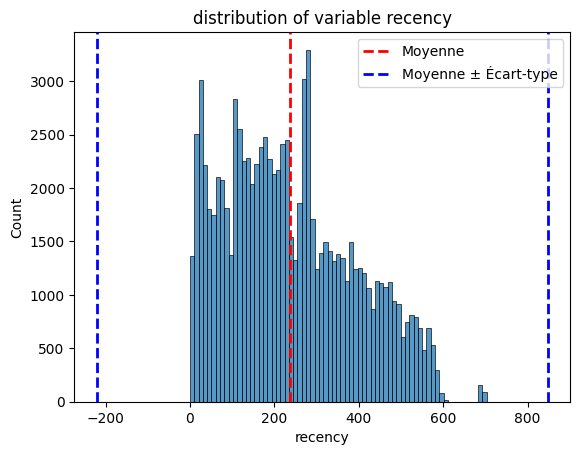

C:\Users\alexi\AppData\Local\Temp\ipykernel_13428\126060999.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



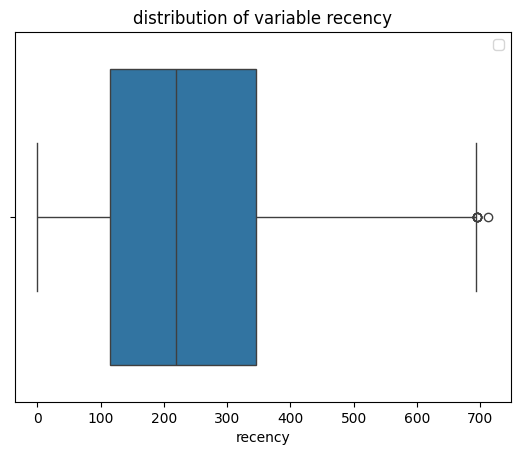

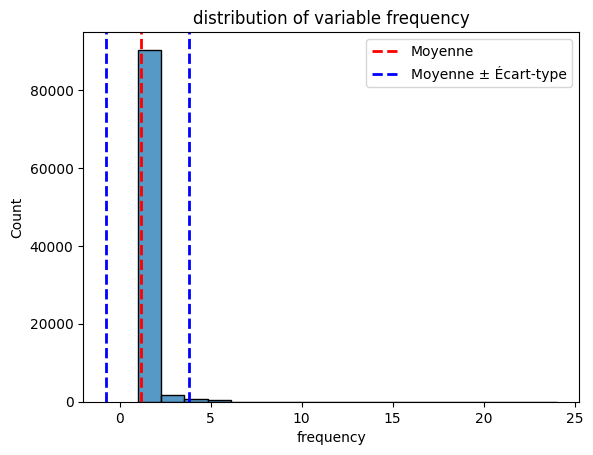

C:\Users\alexi\AppData\Local\Temp\ipykernel_13428\126060999.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



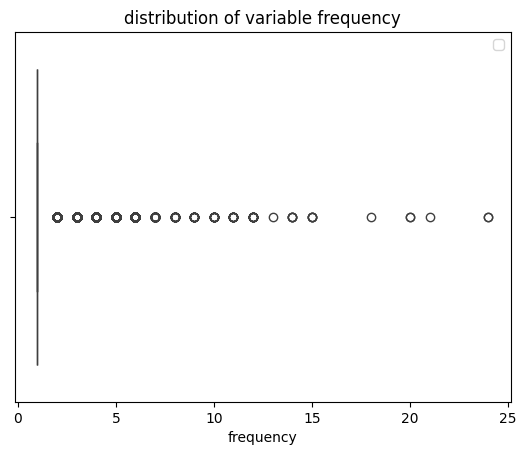

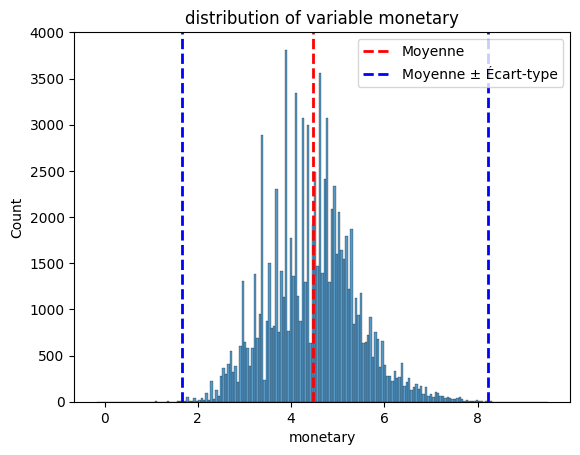

C:\Users\alexi\AppData\Local\Temp\ipykernel_13428\126060999.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



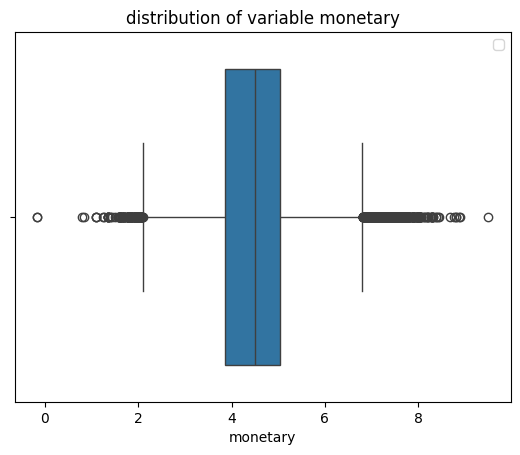

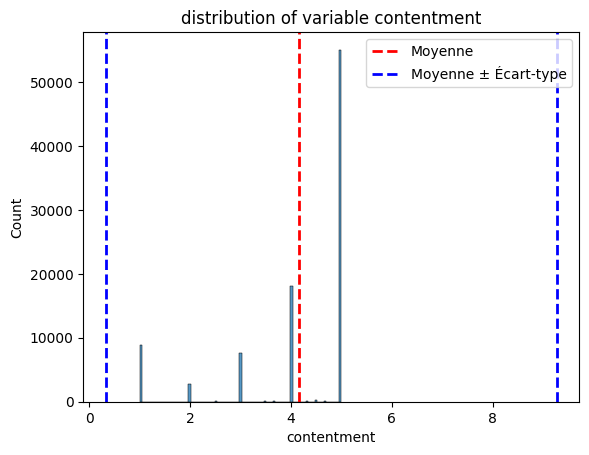

C:\Users\alexi\AppData\Local\Temp\ipykernel_13428\126060999.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



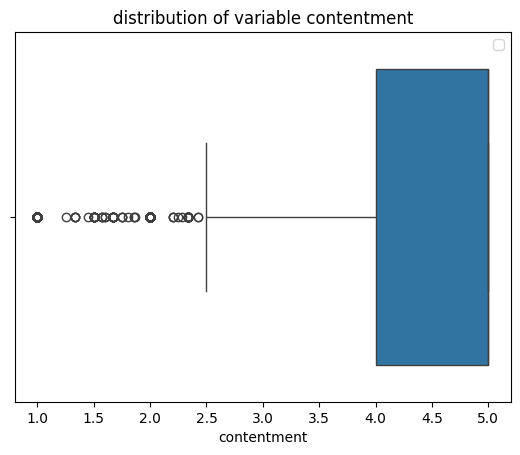

In [80]:
for col in ["recency", "frequency", "monetary", "contentment"]:
    if col == "monetary":
        values = np.log(agg[col])
    else:
        values = agg[col]
        
    mean_val = values.mean()
    std_val = values.std()
    
    sns.histplot(values)
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label='Moyenne')
    plt.axvline(mean_val - 3*std_val, color='blue', linestyle='dashed', linewidth=2, label='Moyenne ± Écart-type')
    plt.axvline(mean_val + 4*std_val, color='blue', linestyle='dashed', linewidth=2)
    
    plt.title(f"distribution of variable {col}")
    plt.legend()
    plt.show()
    
    sns.boxplot(data=values, orient="h")
    plt.title(f"distribution of variable {col}") 
    plt.legend()
    plt.show()

In [81]:
agg["monetary"] = np.log(agg["monetary"])
# std = agg["monetary"].std()
# mean = agg["monetary"].mean()
# agg = agg.loc[agg["monetary"] < mean + 4 *std, ]
# data = agg.loc[agg["monetary"] > mean - 3 *std, ]

## Normaliser les données

In [82]:
scaler = StandardScaler()
agg["monetary"] = scaler.fit_transform(agg[["monetary"]])
agg["recency"] = scaler.fit_transform(agg[["recency"]])
agg["contentment"] = scaler.fit_transform(agg[["contentment"]])

In [83]:
agg.describe()

frequency       recency      monetary   contentment
count  93358.000000  9.335800e+04  9.335800e+04  9.335800e+04
mean       1.187258 -8.828698e-17 -5.692988e-17  3.068734e-16
std        0.650815  1.000005e+00  1.000005e+00  1.000005e+00
min        1.000000 -1.556524e+00 -4.932007e+00 -2.471298e+00
25%        1.000000 -8.094540e-01 -6.430035e-01 -1.242587e-01
50%        1.000000 -1.213630e-01  2.934172e-02  6.580877e-01
75%        1.000000  7.108993e-01  6.091435e-01  6.580877e-01
max       24.000000  3.115941e+00  5.359050e+00  6.580877e-01

<Axes: >

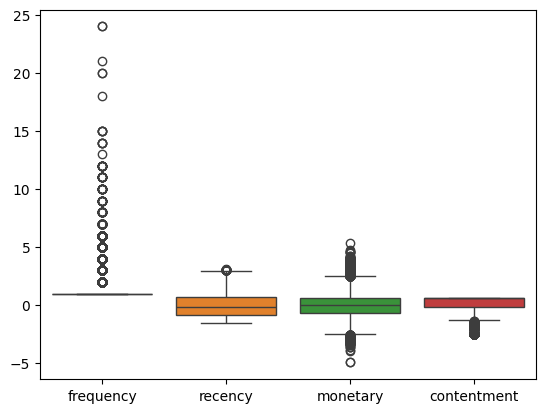

In [84]:
sns.boxplot(data=agg)

<Axes: >

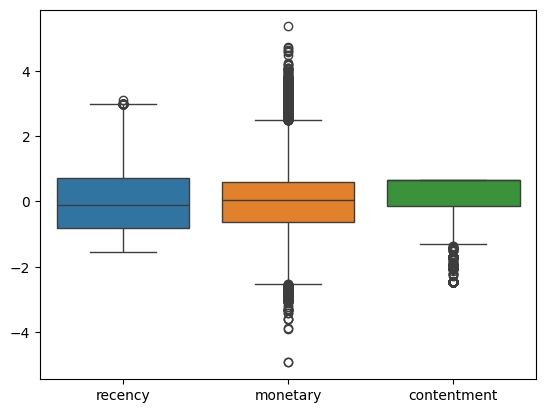

In [85]:
sns.boxplot(data=agg[["recency", "monetary", "contentment"]])

In [86]:
fig = px.scatter_3d(
    agg,
    x='recency',
    y='frequency',
    z='monetary',
    title='3D Scatter Plot',
    opacity=0.8
)

# Personnalisation
fig.update_traces(marker=dict(size=5))  # Taille des points
fig.update_layout(scene=dict(
    xaxis_title='Recency Score',
    yaxis_title='Frequency Score',
    zaxis_title='Monetary Score'
))

# Afficher l'interactivité
fig.show()

In [87]:
fig = px.scatter_3d(
    agg,
    x='recency',
    y='contentment',
    z='monetary',
    title='3D Scatter Plot',
    opacity=0.8
)

# Personnalisation
fig.update_traces(marker=dict(size=5))  # Taille des points
fig.update_layout(scene=dict(
    xaxis_title='Recency Score',
    yaxis_title='Contentment Score',
    zaxis_title='Monetary Score'
))

# Afficher l'interactivité
fig.show()

In [89]:
agg.to_csv("data_cleaned.csv")